# Báo cáo: Tự Lập Trình PCA và Ứng Dụng Trực Quan Hóa Dữ Liệu Ung Thư Vú

## I. Giới thiệu

**Mục tiêu:** Báo cáo này trình bày việc tự xây dựng lại thuật toán Phân tích Thành phần Chính (Principal Component Analysis - PCA) từ đầu bằng Python và ứng dụng thuật toán này vào bộ dữ liệu Ung thư vú Wisconsin (Breast Cancer Wisconsin (Diagnostic) Dataset) để giảm chiều dữ liệu và trực quan hóa. Chúng ta cũng sẽ khám phá ảnh hưởng của việc thay đổi số lượng thành phần chính (trị riêng) được sử dụng đến kết quả trực quan hóa và lượng thông tin được giữ lại.

**PCA là gì?** PCA là một kỹ thuật giảm chiều dữ liệu phổ biến, giúp biến đổi một tập hợp các biến có khả năng tương quan với nhau thành một tập hợp các biến mới không tương quan tuyến tính, được gọi là các thành phần chính. Các thành phần chính này được sắp xếp theo thứ tự giảm dần của phương sai, nghĩa là thành phần chính đầu tiên nắm giữ nhiều thông tin nhất (phương sai lớn nhất) của dữ liệu gốc.

**Bộ dữ liệu Ung thư vú Wisconsin:**
* **Đặc điểm:** Dữ liệu về các đặc trưng hạt nhân của các khối u được số hóa.
* **Số chiều:** 30 thuộc tính (mean radius, mean texture, etc.).
* **Số mẫu:** 569 mẫu.
* **Số lớp:** 2 loại (lành tính - Benign và ác tính - Malignant).
* **Tại sao phù hợp cho PCA cơ bản?**
    * Số chiều cao (30 chiều) làm nổi bật khả năng giảm chiều của PCA để dễ dàng trực quan hóa.
    * Dữ liệu có 2 lớp rõ ràng, PCA có thể giúp tìm ra các thành phần chính phân biệt hai lớp này.
    * Dễ dàng truy cập qua `sklearn.datasets`.

## II. Thư viện cần thiết

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D # Cho biểu đồ 3D

# Cấu hình hiển thị biểu đồ đẹp hơn (tùy chọn)
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10

## III. Tự Lập Trình Mô Hình PCA

Các bước chính để thực hiện PCA:
1.  **Chuẩn hóa dữ liệu (Standardization):** Đưa các đặc trưng về cùng một thang đo, thường là có trung bình bằng 0 và phương sai bằng 1.
2.  **Tính ma trận hiệp phương sai (Covariance Matrix):** Đo lường mối quan hệ tuyến tính giữa các cặp đặc trưng.
3.  **Tính trị riêng (Eigenvalues) và vector riêng (Eigenvectors) của ma trận hiệp phương sai:** Vector riêng chỉ hướng của các thành phần chính, trị riêng cho biết lượng phương sai mà mỗi thành phần chính đó giải thích được.
4.  **Sắp xếp các trị riêng và vector riêng tương ứng:** Sắp xếp theo thứ tự giảm dần của trị riêng.
5.  **Chọn k vector riêng hàng đầu:** Đây là k thành phần chính quan trọng nhất, tạo thành ma trận chiếu W.
6.  **Chiếu dữ liệu gốc lên không gian k chiều mới:** $X_{new} = X_{standardized} \cdot W$

In [18]:
class CustomPCA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.principal_components = None
        self.mean_vector = None
        self.explained_variance_ratio_ = None # Giữ lại dấu gạch dưới theo convention của sklearn

    def fit(self, X):
        # Bước 1: Tính vector trung bình của dữ liệu đầu vào
        self.mean_vector = np.mean(X, axis=0)
        # Bước 1 (tiếp): Trừ giá trị trung bình khỏi dữ liệu (centering a.k.a data mean normalization)
        x_centered = X - self.mean_vector

        # Bước 2: Tính ma trận hiệp phương sai
        # rowvar=False vì mỗi cột là một biến (đặc trưng), mỗi hàng là một mẫu (quan sát)
        covariance_matrix = np.cov(x_centered, rowvar=False)

        # Bước 3: Tính trị riêng và vector riêng của ma trận hiệp phương sai
        eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

        # Bước 4: Sắp xếp các trị riêng và vector riêng tương ứng
        # Vector riêng trong np.linalg.eig được trả về dưới dạng các cột.
        # Ta chuyển vị để mỗi hàng là một vector riêng, thuận tiện cho việc sắp xếp và chọn lựa.
        eigenvectors_transposed = eigenvectors.T 
        # Lấy chỉ số để sắp xếp các trị riêng theo thứ tự giảm dần
        sorted_indices = np.argsort(eigenvalues)[::-1] 

        sorted_eigenvalues = eigenvalues[sorted_indices]
        sorted_eigenvectors = eigenvectors_transposed[sorted_indices]

        # Bước 5: Chọn k vector riêng hàng đầu (tương ứng với k trị riêng lớn nhất)
        self.principal_components = sorted_eigenvectors[0:self.n_components]

        # Tính tỷ lệ phương sai được giải thích bởi từng thành phần chính đã chọn
        total_variance = np.sum(sorted_eigenvalues) # Tổng phương sai là tổng các trị riêng
        explained_variance_by_selected_components = sorted_eigenvalues[:self.n_components]
        self.explained_variance_ratio_ = explained_variance_by_selected_components / total_variance

    def transform(self, X):
        # Bước 6: Chiếu dữ liệu (đã trừ trung bình) lên không gian các thành phần chính
        x_centered = X - self.mean_vector
        x_projected = np.dot(x_centered, self.principal_components.T)
        return x_projected

    def fit_transform(self, X):
        # Kết hợp fit và transform
        self.fit(X)
        return self.transform(X)

## IV. Ứng Dụng PCA vào Dữ Liệu Ung Thư Vú

### 4.1. Tải và Chuẩn bị Dữ liệu

In [19]:
cancer_data = load_breast_cancer()
X_original = cancer_data.data
y_labels = cancer_data.target # 0: Malignant (ác tính), 1: Benign (lành tính)
feature_names = cancer_data.feature_names
target_names = cancer_data.target_names

print(f"Số chiều ban đầu (số đặc trưng): {X_original.shape[1]}")
print(f"Số mẫu: {X_original.shape[0]}")
print(f"Số lớp: {len(np.unique(y_labels))}")
print(f"Tên các lớp: {target_names}")

Số chiều ban đầu (số đặc trưng): 30
Số mẫu: 569
Số lớp: 2
Tên các lớp: ['malignant' 'benign']


**Chuẩn hóa dữ liệu:** Đây là bước quan trọng trước khi áp dụng PCA, vì PCA nhạy cảm với phương sai của các biến. Nếu các biến có thang đo khác nhau, biến có phương sai lớn hơn sẽ chi phối kết quả.

In [20]:
standard_scaler = StandardScaler() # Khởi tạo đối tượng StandardScaler
# Chuẩn hóa dữ liệu: trừ trung bình và chia cho độ lệch chuẩn để có trung bình 0, phương sai 1
x_scaled = standard_scaler.fit_transform(X_original)

### 4.2. Trực quan hóa với 2 Thành phần chính (2D)

Tỷ lệ phương sai giải thích bởi 2 thành phần chính: [0.44272026 0.18971182]
Tổng tỷ lệ phương sai giải thích: 0.6324


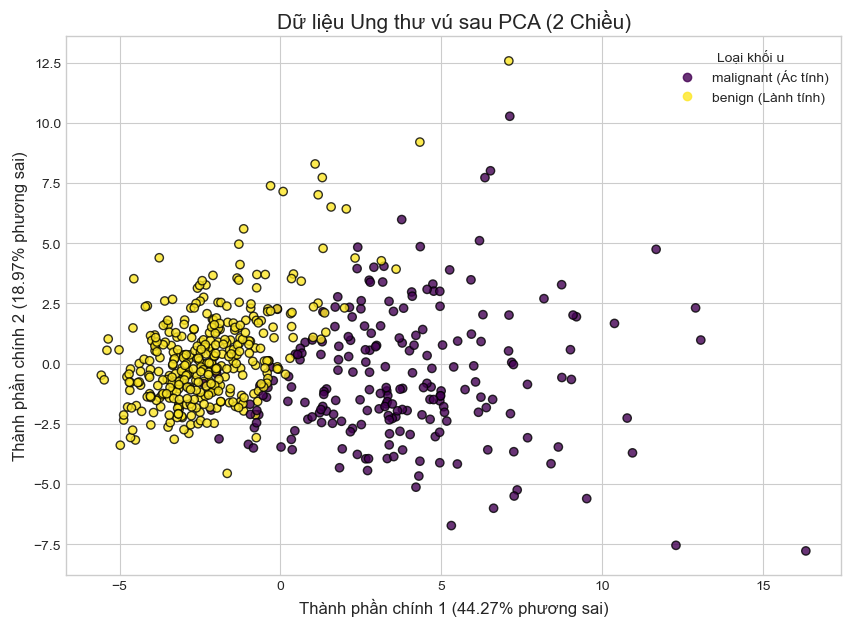

In [21]:
# Khởi tạo và áp dụng PCA với 2 thành phần chính
pca_2d_custom = CustomPCA(n_components=2)
x_pca_2d = pca_2d_custom.fit_transform(x_scaled)

print(f"Tỷ lệ phương sai giải thích bởi 2 thành phần chính: {pca_2d_custom.explained_variance_ratio_}")
print(f"Tổng tỷ lệ phương sai giải thích: {np.sum(pca_2d_custom.explained_variance_ratio_):.4f}")

plt.figure(figsize=(10, 7))
scatter_plot = plt.scatter(x_pca_2d[:, 0], x_pca_2d[:, 1], c=y_labels, cmap='viridis', edgecolor='k', alpha=0.8)
plt.title('Dữ liệu Ung thư vú sau PCA (2 Chiều)', fontsize=15)
plt.xlabel(f'Thành phần chính 1 ({pca_2d_custom.explained_variance_ratio_[0]*100:.2f}% phương sai)')
plt.ylabel(f'Thành phần chính 2 ({pca_2d_custom.explained_variance_ratio_[1]*100:.2f}% phương sai)')

# Tạo chú thích rõ ràng hơn cho biểu đồ
legend_handles, _ = scatter_plot.legend_elements()
plt.legend(legend_handles, [target_names[0] + ' (Ác tính)', target_names[1] + ' (Lành tính)'], title='Loại khối u')
plt.grid(True)
plt.show()

**Nhận xét:**
Khi giảm xuống còn 2 chiều, chúng ta có thể thấy hai lớp (ác tính và lành tính) có xu hướng tách biệt khá tốt. Thành phần chính thứ nhất (PC1) giải thích được khoảng 44.27% phương sai và thành phần chính thứ hai (PC2) giải thích được khoảng 18.97% phương sai. Tổng cộng, 2 thành phần này nắm giữ khoảng 63.24% thông tin phương sai của dữ liệu gốc 30 chiều.

### 4.3. Trực quan hóa với 3 Thành phần chính (3D)

Tỷ lệ phương sai giải thích bởi 3 thành phần chính: [0.44272026 0.18971182 0.09393163]
Tổng tỷ lệ phương sai giải thích: 0.7264


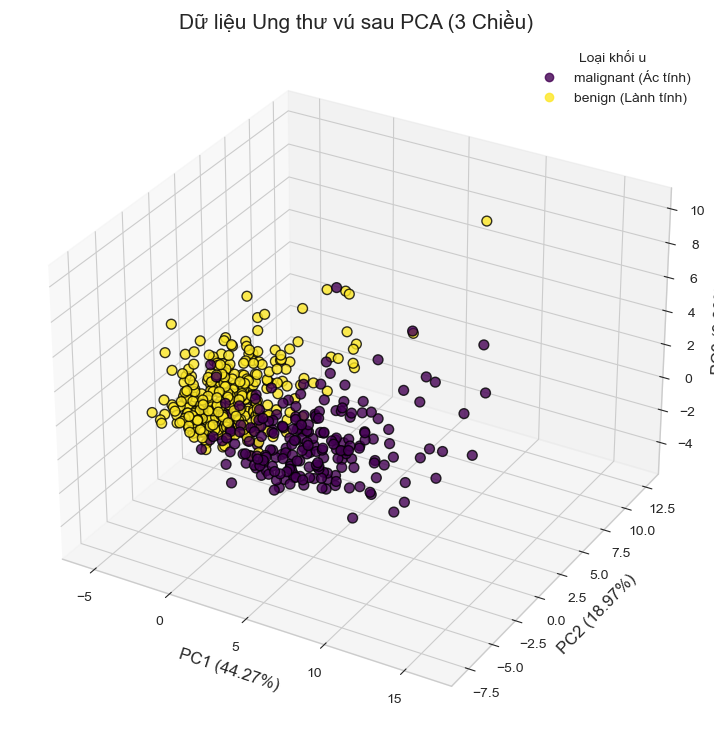

In [22]:
# Khởi tạo và áp dụng PCA với 3 thành phần chính
pca_3d_custom = CustomPCA(n_components=3)
x_pca_3d = pca_3d_custom.fit_transform(x_scaled)

print(f"Tỷ lệ phương sai giải thích bởi 3 thành phần chính: {pca_3d_custom.explained_variance_ratio_}")
print(f"Tổng tỷ lệ phương sai giải thích: {np.sum(pca_3d_custom.explained_variance_ratio_):.4f}")

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')
scatter_plot_3d = ax.scatter(x_pca_3d[:, 0], x_pca_3d[:, 1], x_pca_3d[:, 2], c=y_labels, cmap='viridis', edgecolor='k', alpha=0.8, s=50)
ax.set_title('Dữ liệu Ung thư vú sau PCA (3 Chiều)', fontsize=15)
ax.set_xlabel(f'PC1 ({pca_3d_custom.explained_variance_ratio_[0]*100:.2f}%)')
ax.set_ylabel(f'PC2 ({pca_3d_custom.explained_variance_ratio_[1]*100:.2f}%)')
ax.set_zlabel(f'PC3 ({pca_3d_custom.explained_variance_ratio_[2]*100:.2f}%)')

# Tạo chú thích rõ ràng hơn cho biểu đồ 3D
legend_handles_3d, _ = scatter_plot_3d.legend_elements()
ax.legend(legend_handles_3d, [target_names[0] + ' (Ác tính)', target_names[1] + ' (Lành tính)'], title='Loại khối u')
plt.grid(True)
plt.show()

**Nhận xét:**
Với 3 thành phần chính, sự phân tách giữa hai lớp có thể trở nên rõ ràng hơn một chút trong không gian 3 chiều. Ba thành phần chính đầu tiên giải thích được khoảng 72.64% tổng phương sai. Việc trực quan hóa 3D cho phép nhìn dữ liệu từ nhiều góc độ hơn.

## V. Thay Đổi Số Lượng Trị Riêng (Thành Phần Chính) và Nhận Xét

Việc chọn số lượng thành phần chính $k$ là một quyết định quan trọng. Chúng ta muốn giảm chiều dữ liệu nhưng vẫn giữ lại đủ thông tin quan trọng. Một cách phổ biến là xem xét **tỷ lệ phương sai tích lũy** giải thích được bởi $k$ thành phần chính đầu tiên.

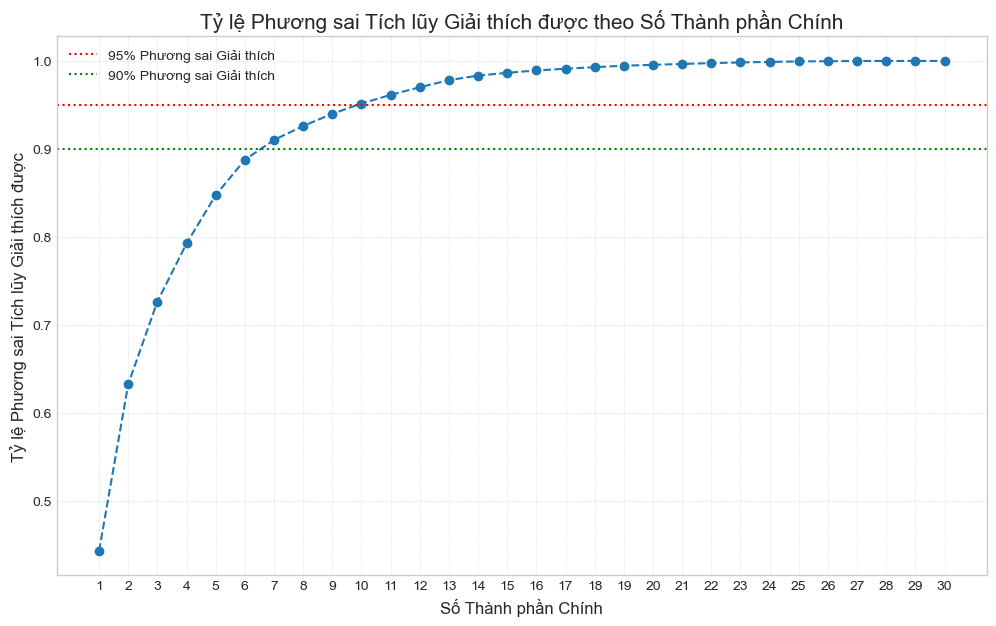

Nhận xét về số lượng thành phần chính:
Với 1 thành phần chính, tỷ lệ phương sai tích lũy giải thích được là: 0.4427
Với 2 thành phần chính, tỷ lệ phương sai tích lũy giải thích được là: 0.6324
Với 3 thành phần chính, tỷ lệ phương sai tích lũy giải thích được là: 0.7264
Với 4 thành phần chính, tỷ lệ phương sai tích lũy giải thích được là: 0.7924
Với 5 thành phần chính, tỷ lệ phương sai tích lũy giải thích được là: 0.8473
Với 6 thành phần chính, tỷ lệ phương sai tích lũy giải thích được là: 0.8876
Với 7 thành phần chính, tỷ lệ phương sai tích lũy giải thích được là: 0.9101
==> Cần 7 thành phần để đạt ít nhất 90% phương sai.
Với 8 thành phần chính, tỷ lệ phương sai tích lũy giải thích được là: 0.9260
Với 9 thành phần chính, tỷ lệ phương sai tích lũy giải thích được là: 0.9399
Với 10 thành phần chính, tỷ lệ phương sai tích lũy giải thích được là: 0.9516
==> Cần 10 thành phần để đạt ít nhất 95% phương sai.
Với 11 thành phần chính, tỷ lệ phương sai tích lũy giải thích được là: 0.9614
Với 12 

In [23]:
cumulative_explained_variance = []
# Duyệt qua số lượng thành phần chính từ 1 đến tổng số đặc trưng ban đầu
n_components_range = range(1, x_scaled.shape[1] + 1) 

for n in n_components_range:
    pca_temp = CustomPCA(n_components=n)
    pca_temp.fit(x_scaled) # Chỉ cần fit để lấy tỷ lệ phương sai giải thích
    cumulative_explained_variance.append(np.sum(pca_temp.explained_variance_ratio_))

plt.figure(figsize=(12, 7))
plt.plot(n_components_range, cumulative_explained_variance, marker='o', linestyle='--')
plt.title('Tỷ lệ Phương sai Tích lũy Giải thích được theo Số Thành phần Chính', fontsize=15)
plt.xlabel('Số Thành phần Chính')
plt.ylabel('Tỷ lệ Phương sai Tích lũy Giải thích được')
plt.xticks(n_components_range)
plt.grid(True, which='both', linestyle=':', linewidth=0.5)
# Vẽ các đường tham chiếu cho ngưỡng phương sai phổ biến
plt.axhline(y=0.95, color='r', linestyle=':', label='95% Phương sai Giải thích') 
plt.axhline(y=0.90, color='g', linestyle=':', label='90% Phương sai Giải thích')
plt.legend(loc='best')
plt.show()

print("Nhận xét về số lượng thành phần chính:")
for i, cumulative_variance in enumerate(cumulative_explained_variance):
    num_components = i + 1
    print(f"Với {num_components} thành phần chính, tỷ lệ phương sai tích lũy giải thích được là: {cumulative_variance:.4f}")
    # In ra thông báo khi đạt các ngưỡng quan trọng
    if num_components > 1: # Để tránh lỗi index khi i=0
        if cumulative_variance >= 0.90 and cumulative_explained_variance[i-1] < 0.90: 
            print(f"==> Cần {num_components} thành phần để đạt ít nhất 90% phương sai.")
        if cumulative_variance >= 0.95 and cumulative_explained_variance[i-1] < 0.95:
            print(f"==> Cần {num_components} thành phần để đạt ít nhất 95% phương sai.")
    elif num_components == 1 and cumulative_variance >= 0.90: # Trường hợp đặc biệt nếu 1 PC đã đủ 90%
         print(f"==> Cần {num_components} thành phần để đạt ít nhất 90% phương sai.")
    elif num_components == 1 and cumulative_variance >= 0.95: # Trường hợp đặc biệt nếu 1 PC đã đủ 95%
         print(f"==> Cần {num_components} thành phần để đạt ít nhất 95% phương sai.")

**Nhận xét chi tiết:**

* **Biểu đồ phương sai tích lũy:** Cho thấy khi tăng số lượng thành phần chính, tổng lượng phương sai của dữ liệu gốc mà chúng ta giữ lại cũng tăng lên. Đường cong này thường tăng nhanh ở những thành phần đầu tiên và sau đó thoải dần (điểm "khuỷu tay" - elbow point, nếu có).
* **Lựa chọn số lượng thành phần:**
    * Để giữ lại khoảng **90%** tổng phương sai, chúng ta cần khoảng **7** thành phần chính.
    * Để giữ lại khoảng **95%** tổng phương sai, chúng ta cần khoảng **10** thành phần chính.
    * Điều này có nghĩa là chúng ta có thể giảm số chiều từ 30 xuống còn 7-10 chiều mà vẫn giữ được phần lớn thông tin quan trọng, hữu ích cho các mô hình học máy sau này hoặc để giảm nhiễu.
* **Trường hợp 1 thành phần chính:**
    Khi chỉ dùng 1 thành phần chính (PC1), chúng ta giữ lại khoảng 44.27% phương sai. Dữ liệu bị chiếu xuống một đường thẳng duy nhất. Mặc dù vẫn có thể thấy một số sự tách biệt tiềm năng giữa hai lớp, nhưng rất nhiều thông tin cấu trúc đã bị mất so với khi dùng 2 hoặc 3 thành phần.

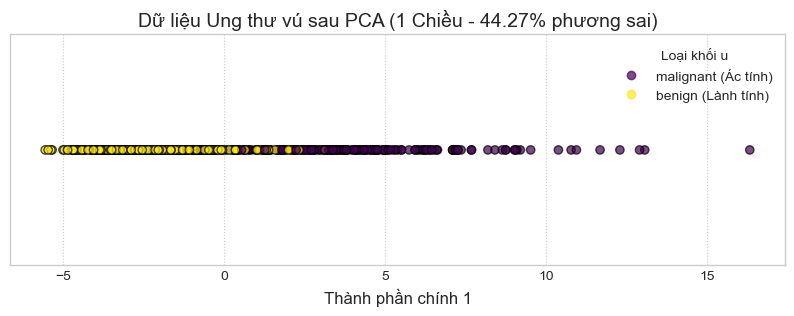

In [24]:
# Minh họa trường hợp 1 thành phần chính
pca_1d_custom = CustomPCA(n_components=1)
x_pca_1d = pca_1d_custom.fit_transform(x_scaled)

plt.figure(figsize=(10, 3))
scatter_plot_1d = plt.scatter(x_pca_1d, np.zeros_like(x_pca_1d), c=y_labels, cmap='viridis', edgecolor='k', alpha=0.7)
plt.title(f'Dữ liệu Ung thư vú sau PCA (1 Chiều - {pca_1d_custom.explained_variance_ratio_[0]*100:.2f}% phương sai)', fontsize=14)
plt.yticks([]) # Bỏ các giá trị trên trục y vì không có ý nghĩa trong biểu đồ 1D này
plt.xlabel('Thành phần chính 1')
legend_handles_1d, _ = scatter_plot_1d.legend_elements()
plt.legend(legend_handles_1d, [target_names[0] + ' (Ác tính)', target_names[1] + ' (Lành tính)'], title='Loại khối u')
plt.grid(axis='x', linestyle=':')
plt.show()

**Đánh đổi (Trade-off):**
* **Ít thành phần chính hơn:**
    * *Ưu điểm:* Giảm chiều mạnh mẽ, giảm nhiễu, dễ trực quan hóa (nếu 2D/3D), mô hình học máy sau đó có thể nhanh hơn và ít bị quá khớp (overfitting) hơn.
    * *Nhược điểm:* Có nguy cơ mất thông tin quan trọng nếu giảm quá nhiều.
* **Nhiều thành phần chính hơn:**
    * *Ưu điểm:* Giữ lại nhiều thông tin hơn của dữ liệu gốc.
    * *Nhược điểm:* Ít lợi ích về giảm chiều, khó trực quan hóa hơn nếu số chiều vẫn còn lớn, có thể vẫn giữ lại nhiễu.

## VI. Kết luận

Qua việc tự lập trình và ứng dụng PCA vào bộ dữ liệu Ung thư vú Wisconsin, chúng ta đã thấy được:
1.  **PCA là một công cụ hiệu quả để giảm chiều dữ liệu.** Từ 30 chiều ban đầu, dữ liệu có thể được biểu diễn trong không gian 2 hoặc 3 chiều mà vẫn giữ được cấu trúc phân tách cơ bản giữa các lớp.
2.  **Việc trực quan hóa dữ liệu nhiều chiều trở nên khả thi sau khi áp dụng PCA.** Điều này giúp ích rất nhiều trong việc khám phá dữ liệu ban đầu.
3.  **Số lượng thành phần chính được chọn ảnh hưởng trực tiếp đến lượng thông tin (phương sai) được giữ lại.** Việc lựa chọn này cần cân nhắc giữa việc giảm chiều và việc bảo toàn thông tin, tùy thuộc vào mục đích sử dụng (trực quan hóa, giảm nhiễu, hay đầu vào cho mô hình học máy khác).